## Import des librairies nécessaires

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
# %matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

ModuleNotFoundError: No module named 'ipympl'

In [2]:
@pims.pipeline
def gray(image):
    return image[:,:]  # Take just the green channel

frames = gray(pims.open('075um_crop.tif')) # changer le chemin du fichier à ouvrirframes = gray(pims.open('C:/Users/Etudiants/Desktop/tpgang/acquisition 1micro_800dilu.tiff')) # changer le chemin du fichier à ouvrir

C:\Users\nicol\anaconda3\lib\site-packages\pims\api.py:204: UserWarning: <class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: 'C:\\Users\\nicol\\Desktop\\SOAC\\075um_MMStack_Default.tiff'
  warn(message)
C:\Users\nicol\anaconda3\lib\site-packages\pims\api.py:204: UserWarning: <class 'pims.imageio_reader.ImageIOReader'> errored: No such file: 'C:\Users\nicol\Desktop\SOAC\075um_MMStack_Default.tiff'
  warn(message)
C:\Users\nicol\anaconda3\lib\site-packages\pims\api.py:204: UserWarning: <class 'pims.bioformats.BioformatsReader'> errored: The file "075um_MMStack_Default.tiff" does not exist.
  warn(message)


UnknownFormatError: All handlers returned exceptions:
<class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: 'C:\\Users\\nicol\\Desktop\\SOAC\\075um_MMStack_Default.tiff'
<class 'pims.imageio_reader.ImageIOReader'> errored: No such file: 'C:\Users\nicol\Desktop\SOAC\075um_MMStack_Default.tiff'
<class 'pims.bioformats.BioformatsReader'> errored: The file "075um_MMStack_Default.tiff" does not exist.


On peut vérifier une image du fichier chargé:

Frame([[40441, 40041, 41226, ..., 24950, 24870, 24533],
       [39465, 39305, 39897, ..., 24341, 25622, 25446],
       [40745, 39065, 40665, ..., 25414, 24678, 24966],
       ...,
       [24662, 24005, 24229, ..., 27446, 27302, 25382],
       [23173, 23973, 23669, ..., 26774, 26598, 25702],
       [24181, 23557, 23605, ..., 26550, 25910, 26758]], dtype=uint16)
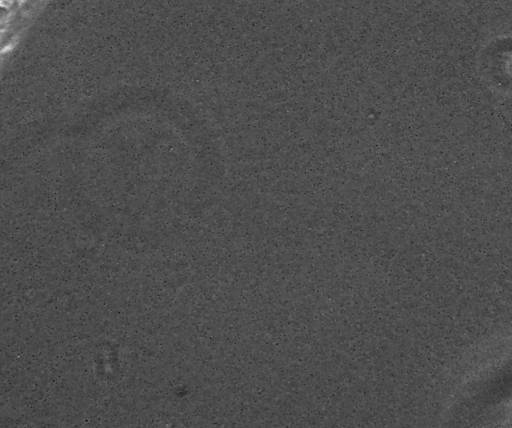

In [3]:
frames[199]


## Détection des particules
Nous allons utiliser le package "trackpy" pour détecter les particules qui sont les plus brillantes dans le plan focal de l'objectif (particules blanches).
les paramètres sont les suivants:
- l'images d'intérêt (frames[??])
- diamètre des billes (en pixel - nombre impair)
- invert = True pour détécter les billes sombres et non claires

In [5]:
f = tp.locate(frames[29],7 , invert=True)


In [6]:
f.head()  # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,3.553398,12.056291,14309.591789,1.954330,0.258500,932.524292,855876.0,-0.064332,29
1,3.381390,78.732490,4852.784007,1.828885,0.426867,486.883305,1035755.0,-0.155005,29
2,3.378339,165.542446,3759.084981,1.650904,0.466674,483.586408,1158310.0,-3.902696,29
3,3.585359,177.691677,4183.389444,1.758725,0.292009,425.984014,1113221.0,-0.394402,29
4,3.130270,240.940638,2505.517539,1.569326,0.617529,356.500348,1149046.0,-1.380207,29


Affichage des particules détectées

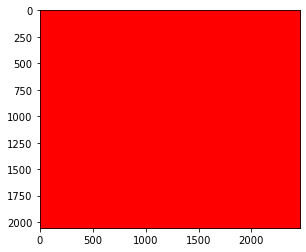

In [6]:
tp.annotate(f, frames[29]);

AttributeError: AxesImage.set() got an unexpected keyword argument 'colormap'

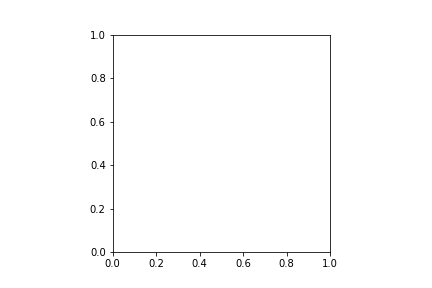

In [18]:
plt.figure()
plt.imshow(frames[29],colormap='gray')
plt.plot(f.x,f.y,'+')
plt.show()

En fonction du résultats, vous pouvez ajuster les paramètres afin d'optimiser la détection des particules qui vous intéressent.
Pour pouvoir faire cela vous pouvez afficher la distribution du nombre de particules en fonction de leur poids (qui correspond à leur brillance).  

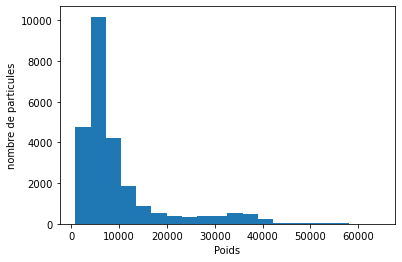

In [7]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='Poids', ylabel='nombre de particules');

Ce graphique vous donne un ordre d'idée des poids des particule et vous permet de fixer un poids seuil en dessous duquel les particules seront exclues.\
Vous pouvez ajuster le poids jusqu'à obtenir une bonne détection de vos particules.\
Rappel: vous cherchez à détecter seulement les particules les plus blanches, celles qui sont bien dans le plan focal de votre objectif, les autres particules risquent de disparaitre au cours du film et donneront seulement des trajectoires courtes.\
\
<span style="color:red"> ***Question :*** *pour quelle.s raison.s les particules peuvent-elles disparaitre?*</span>

In [13]:
f = tp.locate(frames[29],7,invert=True, minmass=45000)

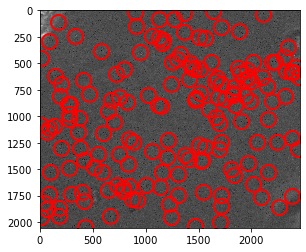

In [14]:
tp.annotate(f, frames[29]);

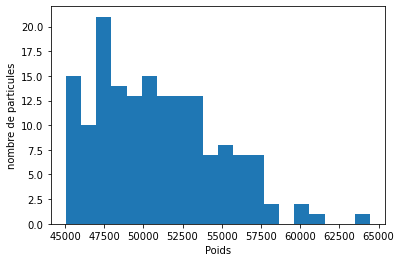

In [15]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='Poids', ylabel='nombre de particules');

Détection des particules dans toutes les images du film. Les positions sont stockées dans la variable f.\
Pensez à remettre les mêmes paramètres que vous avez optimisés pour la la 1ère image.

In [16]:

f = tp.batch(frames[:], 7, invert=True, minmass=45000);

Frame 199: 154 features


## Génération des trajectoires
Une fois les particules détectées pour chaque image du film, vous devez maintenant reliées entre elles ces particules d'une image à l'autre de manière à obtenir la trajectoire dans le temps de chacune d'entre elles.\
Pour cela, utiliser la fonction link toujours dans le package "trackpy".\
Les paramètres sont les suivants: 
- les positions des particules détectée auparavant, stockées dans "f"
- le rayon possible dans lequel les particules peuvent se déplacer entre deux images successives. Plus ce rayon est grand plus le temps de calcul est élevé, mais si il est trop petit, vous pouvez perdre vos particules au cours du temps).
- nombre de d'images où on autorise l'algorithme à perdre la particule et la retrouver.

In [17]:
# tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, 7, memory=3)

Frame 199: 154 trajectories present.


In [18]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,25.994183,1366.039975,49876.451560,1.739599,0.013752,3812.790423,1353245.0,0.104464,0,0
100,1388.402031,1204.924783,52440.122735,1.826931,0.190397,3602.808153,1397832.0,0.084579,0,1
101,1397.149367,1876.585756,48218.849948,1.805243,0.089181,3443.866518,1360765.0,0.100480,0,2
102,1409.010564,424.662739,45816.401116,1.887009,0.079777,2787.259037,1397415.0,0.084730,0,3
103,1411.161348,897.211306,54693.067337,1.741738,0.066141,3982.191850,1383813.0,0.089963,0,4


In [19]:
t1 = tp.filter_stubs(t, 20)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())
t1.head()
#t1.particule()

Before: 1722
After: 327


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,25.994183,1366.039975,49876.451560,1.739599,0.013752,3812.790423,1353245.0,0.104464,0,0
0,1388.402031,1204.924783,52440.122735,1.826931,0.190397,3602.808153,1397832.0,0.084579,0,1
0,1409.010564,424.662739,45816.401116,1.887009,0.079777,2787.259037,1397415.0,0.084730,0,3
0,1412.054828,1533.961351,49519.638991,1.716885,0.026140,3854.944167,1347241.0,0.107880,0,5
0,1417.263222,2285.903780,56664.777258,1.864112,0.185696,3516.455894,1424237.0,0.076010,0,6


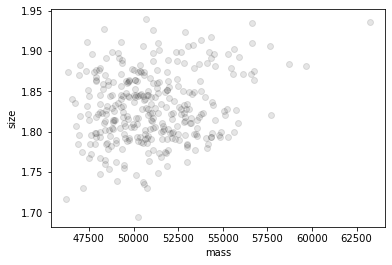

In [20]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

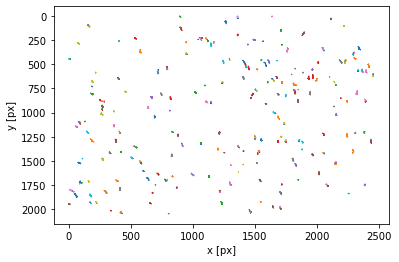

In [21]:
plt.figure()
tp.plot_traj(t1);

In [23]:
d = tp.compute_drift(t1)


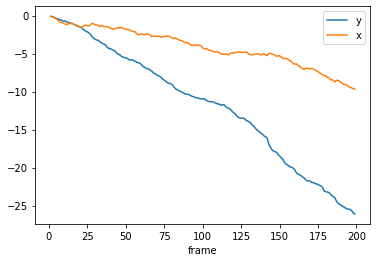

In [24]:
d.plot()
plt.show()

In [25]:
tm = tp.subtract_drift(t1.copy(), d)

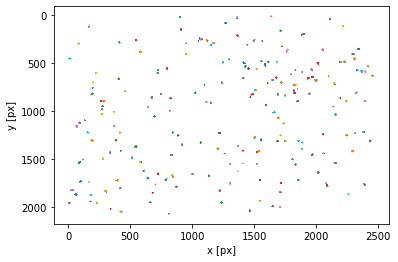

In [26]:
ax = tp.plot_traj(tm)
plt.show()

In [27]:
im = tp.imsd(tm, 2*3.45/40, 10)  # microns per pixel = binning*3.45/40, frames per second = 10

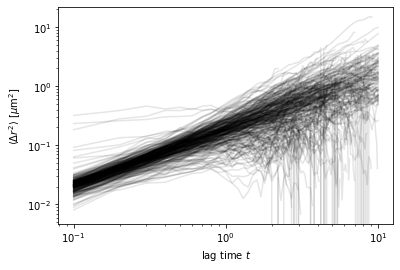

In [28]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [40]:
em = tp.emsd(tm, 1*330/1040, 10)  # microns per pixel = binning*330/1040, frames per second = 10

[Text(0, 0.5, '$\\langle \\Delta r^2 \\rangle$ [$\\mu$m$^2$]'),
 Text(0.5, 0, 'lag time $t$')]

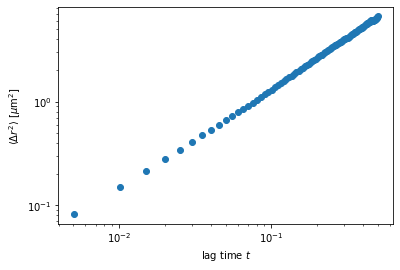

In [41]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')


## FIN du Notebook

In [42]:
em

lagt
0.005025    0.082343
0.010050    0.149296
0.015075    0.214701
0.020101    0.279541
0.025126    0.344173
              ...   
0.482412    6.224511
0.487437    6.306233
0.492462    6.399727
0.497487    6.491664
0.502513    6.616563
Name: msd, Length: 100, dtype: float64

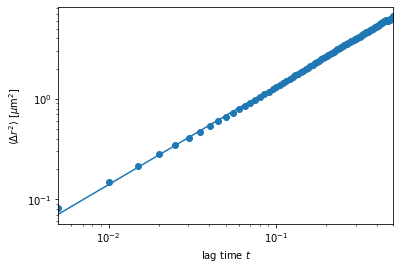

,n,A
msd,0.982338,12.858114


In [43]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots